In [1]:
import pandas as pd
import numpy as np
import hvplot.xarray

import matplotlib.pyplot as plt
import matplotlib as mpl

import sys
sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/DataAccess/Utilities')
import PreProcess_Utils as pputil

sys.path.append('C:/Users/mbonney/OneDrive - NRCan RNCan/Projects/UtilityCode/Modelling/Utilities')
import Snow_Utils as snow_util

In [2]:
# from dask.distributed import LocalCluster

# cluster = LocalCluster(n_workers = 10, threads_per_worker = 10, memory_limit = 0) # Refined through testing, removing memory_limit is important
# client = cluster.get_client()
# client # Can open in other window by clicking 'Dashboard' link below

In [3]:
# Calculated from IMS (4 SnowDynamics_IMS)
sstart_first = 248
send_last = 166
smin_avg = 205

In [4]:
w_s = 2020 # Year that winter ends
w_e = 2021 # Year that winter starts
winterYear = str(w_s)[2:] + str(w_e)[2:] 

path = r'C:\Users\mbonney\OneDrive - NRCan RNCan\Projects\High Resolution Snow Dynamics\Fmask_V1\AA\Alaska Snow Depth\1 HLS Fmask from STAC\fmask_nc'

# Full Process to Winter Year Snow Dynamics

In [5]:
%%time
c_s = pputil.uploadNC(path + '/fmask_AlaskaSite_' + str(w_s) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_s

CPU times: total: 0 ns
Wall time: 543 ms


<xarray.DataArray 'stackstac-4a49170135b6085f2749f5154223a8f7' (time: 187,
                                                                band: 1,
                                                                y: 2436, x: 1581)> Size: 720MB
dask.array<open_dataset-stackstac-4a49170135b6085f2749f5154223a8f7, shape=(187, 1, 2436, 1581), dtype=uint8, chunksize=(1, 1, 2436, 1581), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y              (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
    constellation  (time) <U3 2kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 1kB 2020-03-02 ... 2020-10-10
Attributes:
    spec:        RasterSpec(epsg=32606, bounds=(399510, 7606260, 446940, 7679...
    crs:         epsg:32606
    transform:   [ 3.00000e+01  0.00000e+00  3.99510e+05  0.00000e+00 -3.0000...
    resolution:  30

In [6]:
%%time
c_e = pputil.uploadNC(path + '/fmask_AlaskaSite_' + str(w_e) + '.nc', 
                      form = 'dataarray',
                      chunks = {'time': 1, 'band': -1, 'x': -1, 'y': -1})
c_e

CPU times: total: 31.2 ms
Wall time: 56.4 ms


<xarray.DataArray 'stackstac-00eb41efa210593677a260c6a0b07bfc' (time: 201,
                                                                band: 1,
                                                                y: 2436, x: 1581)> Size: 774MB
dask.array<open_dataset-stackstac-00eb41efa210593677a260c6a0b07bfc, shape=(201, 1, 2436, 1581), dtype=uint8, chunksize=(1, 1, 2436, 1581), chunktype=numpy.ndarray>
Coordinates:
  * band           (band) <U5 20B 'Fmask'
  * x              (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y              (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
    constellation  (time) <U3 2kB dask.array<chunksize=(1,), meta=np.ndarray>
  * time           (time) datetime64[ns] 2kB 2021-03-02 ... 2021-10-10
Attributes:
    spec:        RasterSpec(epsg=32606, bounds=(399510, 7606260, 446940, 7679...
    crs:         epsg:32606
    transform:   [ 3.00000e+01  0.00000e+00  3.99510e+05  0.00000e+00 -3.0000...
    resolution:  30

In [7]:
%%time
snowCube = snow_util.annualFmask2SnowCube(c_s, c_e, yrs = 2, verbose = True) # yrs = 1, doy = doy
# Want to use 2 year cube to help get better results due to date gaps
snowCube

Initial Fmask time-steps: Start (n = 187), End (n = 201).
Made decision on same-day observations (L30vS30): Start (n = 148), End (n = 159).
Combined snow cube (n = 307).
Removed time-steps above 99% unclear pixels (n = 221).
Reclassifed (Snow = 1, Non-snow = 0, Unclear = NaN)
CPU times: total: 42.2 s
Wall time: 12.4 s


<xarray.DataArray 'stackstac-4a49170135b6085f2749f5154223a8f7' (time: 221,
                                                                y: 2436, x: 1581)> Size: 3GB
dask.array<where, shape=(221, 2436, 1581), dtype=float32, chunksize=(1, 2436, 1581), chunktype=numpy.ndarray>
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y            (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
  * time         (time) datetime64[ns] 2kB 2020-03-05 2020-03-06 ... 2021-10-10
    spatial_ref  int64 8B 0

In [8]:
thresh = 2 # Originally 3 but in some situations leads to extra uncertainty


if np.isnan(send_last) == True:
    implausible_snow = []
else: # Week buffer from latest recorded end date and earliest recorded start date
    implausible_snow = [send_last + 7, sstart_first - 7]

implausible_snow

[173, 241]

In [9]:
# %%time
# snowCube_c = snow_util.cleanSnowCube(snowCube, implausible_snow = implausible_snow, thresh = thresh)
# snowCube_c

In [10]:
# %%time
# snowCube_c = snow_util.dailySnowCube(snowCube_c, doy = int(tile_stats.loc[tile, 'smin_avg']), verbose = True)
# snowCube_c

In [11]:
# %%time
# snowDynamics = snow_util.dailySnowCube2SnowDynamics(snowCube_c, uncertainty = True, verbose = True) # Default settings
# snowDynamics

# Load Snow Cube

In [12]:
%%time
snowCube = pputil.loadXR(snowCube)
snowCube

[########################################] | 100% Completed | 11.58 s
CPU times: total: 53.3 s
Wall time: 15.1 s


<xarray.DataArray 'stackstac-4a49170135b6085f2749f5154223a8f7' (time: 221,
                                                                y: 2436, x: 1581)> Size: 3GB
array([[[ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        [ 1.,  1.,  1., ...,  1.,  1.,  1.],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        [ 1.,  1.,  1., ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 13kB 3.995e+05 3.996e+05 ... 4.469e+05 4.469e+05
  * y            (y) float64 19kB 7.679e+06 7.679e+06 ... 7.606e+06 7.606e+06
  * time         (time) datetime64[ns] 2kB 2020-03-05 2020-03-06 ... 2021-10-10
    spatial_ref  int64 8B 0

# Select pixel with topographic shadows + high uncertiaines and late start, short length
- x: 2150, y: 1300

In [13]:
x = 2150 #np.random.randint(0, snowCube.shape[1])
print(x)
y = 1300 #np.random.randint(0, snowCube.shape[2])
print(y)

print(snowCube[:, x, y]['x'].values) #.rio.set_spatial_dims('x', 'y').rio.reproject('EPSG:4326')
print(snowCube[:, x, y]['y'].values)

(snowCube[:, x, y].rename('Snow Cube') # To plot with hvplot
                  .dropna(dim = 'time') # Prepare for daily resample
                  .resample(time = '1D').interpolate('linear').astype('float32') # Linear daily resample
                  # Reindex to fill 2 year time-series?
                  .hvplot(height = 600, width = 1500) * # Drop na and interpolate na to see full picture

(snowCube[:, x, y].hvplot.scatter(marker = 'o', color = 'black', size = 15))) # Observation points

2150
1300
438525.0
7614825.0


:Overlay
   .Curve.I   :Curve   [time]   (Snow Cube)
   .Scatter.I :Scatter   [time]   (stackstac-4a49170135b6085f2749f5154223a8f7)

# Get Results in Dataframe for Matplotlib

In [14]:
time_index = pd.date_range(start = str(w_s) + '-01-01', end = str(w_e) + '-12-31')
time_index

DatetimeIndex(['2020-01-01', '2020-01-02', '2020-01-03', '2020-01-04',
               '2020-01-05', '2020-01-06', '2020-01-07', '2020-01-08',
               '2020-01-09', '2020-01-10',
               ...
               '2021-12-22', '2021-12-23', '2021-12-24', '2021-12-25',
               '2021-12-26', '2021-12-27', '2021-12-28', '2021-12-29',
               '2021-12-30', '2021-12-31'],
              dtype='datetime64[ns]', length=731, freq='D')

In [15]:
df = snowCube[:, x, y].rename('SnowCube_line').dropna(dim = 'time').resample(time = '1D').interpolate('linear').astype('float32').to_dataframe()
df = df.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)
df = df.reindex(time_index, method = 'nearest')
df

,SnowCube_line
2020-01-01,1.0
2020-01-02,1.0
2020-01-03,1.0
2020-01-04,1.0
2020-01-05,1.0
...,...
2021-12-27,1.0
2021-12-28,1.0
2021-12-29,1.0
2021-12-30,1.0


In [16]:
df1 = snowCube[:, x, y].to_dataframe()
df1 = df1.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)
df1 = df1.rename(columns = {'stackstac-4a49170135b6085f2749f5154223a8f7': 'SnowCube_pts'})

def unclear_pts(x):
    if np.isnan(x) == True:
        return -0.05

df1['unclear_pts'] = df1['SnowCube_pts'].apply(unclear_pts)

df1

,SnowCube_pts,unclear_pts
time,,
2020-03-05,NaN,-0.05
2020-03-06,NaN,-0.05
2020-03-07,NaN,-0.05
2020-03-13,NaN,-0.05
2020-03-22,NaN,-0.05
...,...,...
2021-09-28,NaN,-0.05
2021-10-03,1.0,NaN
2021-10-06,NaN,-0.05


In [17]:
df2 = pd.merge(df, df1, how = 'outer', left_index = True, right_index = True)
df2['unclear_line'] = -0.05
df2

,SnowCube_line,SnowCube_pts,unclear_pts,unclear_line
2020-01-01,1.0,NaN,NaN,-0.05
2020-01-02,1.0,NaN,NaN,-0.05
2020-01-03,1.0,NaN,NaN,-0.05
2020-01-04,1.0,NaN,NaN,-0.05
2020-01-05,1.0,NaN,NaN,-0.05
...,...,...,...,...
2021-12-27,1.0,NaN,NaN,-0.05
2021-12-28,1.0,NaN,NaN,-0.05
2021-12-29,1.0,NaN,NaN,-0.05
2021-12-30,1.0,NaN,NaN,-0.05


In [18]:
thresh = 2

snowCube_c = snow_util.cleanSnowCube(snowCube[:, x-5:x+5, y-5:y+5], implausible_snow = implausible_snow, thresh = thresh)
snowCube_c

Set all observations to non-snow between implausible snow dates (06-21 to 08-28).
Calculated cumulative sum that resets when non-snow is found.
Identified periods when 2+ consecutive snow observations occured (skipping NaN).
Created flipped snowCube to identify non-snow periods.
Calculated cumulative sum that resets when snow is found.
Identified periods when 2+ consecutive non-snow observations occured (skipping NaN).
Removed (NaN) snow and non-snow periods below 2 consecutive observations.


<xarray.DataArray (time: 221, y: 10, x: 10)> Size: 88kB
array([[[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ...,  1.,  1., nan],
        [nan, nan, nan, ...,  1.,  1.,  1.],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
...
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]],

       [[nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        ...,
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan],
        [nan, nan, nan, ..., nan, nan, nan]]], dtype=float32)
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 80B 4.384e+05 4.384e+05 ... 4.386e+05 4.386e+05
  * y            (y) float64 80B 7.615e+06 7.615e+06 ... 7.615e+06 7.615e+06
  * time         (time) datetime64[ns] 2kB 2020-03-05 2020-03-06 ... 2021-10-10
    spatial_ref  int64 8B 0

In [19]:
df = snowCube_c[:, 5, 5].rename('SnowCube_c_line').dropna(dim = 'time').resample(time = '1D').interpolate('linear').astype('float32').to_dataframe()
df = df.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)
df = df.reindex(time_index, method = 'nearest')
df

,SnowCube_c_line
2020-01-01,1.0
2020-01-02,1.0
2020-01-03,1.0
2020-01-04,1.0
2020-01-05,1.0
...,...
2021-12-27,0.0
2021-12-28,0.0
2021-12-29,0.0
2021-12-30,0.0


In [20]:
df1 = snowCube_c[:, 5, 5].rename('SnowCube_c_pts').to_dataframe()
df1 = df1.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)

def unclear_pts(x):
    if np.isnan(x) == True:
        return -0.05

df1['unclear_c_pts'] = df1['SnowCube_c_pts'].apply(unclear_pts)

df1

,SnowCube_c_pts,unclear_c_pts
time,,
2020-03-05,NaN,-0.05
2020-03-06,NaN,-0.05
2020-03-07,NaN,-0.05
2020-03-13,NaN,-0.05
2020-03-22,NaN,-0.05
...,...,...
2021-09-28,NaN,-0.05
2021-10-03,NaN,-0.05
2021-10-06,NaN,-0.05


In [21]:
df2 = pd.merge(df2, df, how = 'outer', left_index = True, right_index = True)
df2 = pd.merge(df2, df1, how = 'outer', left_index = True, right_index = True)
df2

,SnowCube_line,SnowCube_pts,unclear_pts,unclear_line,SnowCube_c_line,SnowCube_c_pts,unclear_c_pts
2020-01-01,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2020-01-02,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2020-01-03,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2020-01-04,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
2020-01-05,1.0,NaN,NaN,-0.05,1.0,NaN,NaN
...,...,...,...,...,...,...,...
2021-12-27,1.0,NaN,NaN,-0.05,0.0,NaN,NaN
2021-12-28,1.0,NaN,NaN,-0.05,0.0,NaN,NaN
2021-12-29,1.0,NaN,NaN,-0.05,0.0,NaN,NaN
2021-12-30,1.0,NaN,NaN,-0.05,0.0,NaN,NaN


In [22]:
snowCube_1D = snow_util.dailySnowCube(snowCube_c, doy = smin_avg, verbose = True)
snowCube_1D

Filled in all NaNs in snowCube with linearly interpolated values in time.
Resampled to daily snowCube (2020-03-05 to 2021-10-10, n = 585) using linear interpolation.
Filtered to winter year (2020-07-25 to 2021-07-24, n = 365).
Reinidexing not required since daily snowCube already contains all possible dates.


<xarray.DataArray (time: 365, y: 10, x: 10)> Size: 146kB
dask.array<getitem, shape=(365, 10, 10), dtype=float32, chunksize=(365, 10, 10), chunktype=numpy.ndarray>
Coordinates:
    band         <U5 20B 'Fmask'
  * x            (x) float64 80B 4.384e+05 4.384e+05 ... 4.386e+05 4.386e+05
  * y            (y) float64 80B 7.615e+06 7.615e+06 ... 7.615e+06 7.615e+06
    spatial_ref  int64 8B 0
  * time         (time) datetime64[ns] 3kB 2020-07-25 2020-07-26 ... 2021-07-24

In [23]:
df = snowCube_1D[:, 5, 5].rename('SnowCube_1D').to_dataframe()
df = df.drop(['band', 'x', 'y', 'spatial_ref'], axis = 1)
df

,SnowCube_1D
time,
2020-07-25,0.0
2020-07-26,0.0
2020-07-27,0.0
2020-07-28,0.0
2020-07-29,0.0
...,...
2021-07-20,0.0
2021-07-21,0.0
2021-07-22,0.0


In [24]:
df2 = pd.merge(df2, df, how = 'outer', left_index = True, right_index = True)
df2

,SnowCube_line,SnowCube_pts,unclear_pts,unclear_line,SnowCube_c_line,SnowCube_c_pts,unclear_c_pts,SnowCube_1D
2020-01-01,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2020-01-02,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2020-01-03,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2020-01-04,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
2020-01-05,1.0,NaN,NaN,-0.05,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...
2021-12-27,1.0,NaN,NaN,-0.05,0.0,NaN,NaN,NaN
2021-12-28,1.0,NaN,NaN,-0.05,0.0,NaN,NaN,NaN
2021-12-29,1.0,NaN,NaN,-0.05,0.0,NaN,NaN,NaN
2021-12-30,1.0,NaN,NaN,-0.05,0.0,NaN,NaN,NaN


In [25]:
#df2[df2['SnowCube_1D'].notnull()].iloc[-1]#.index

# Plot 1

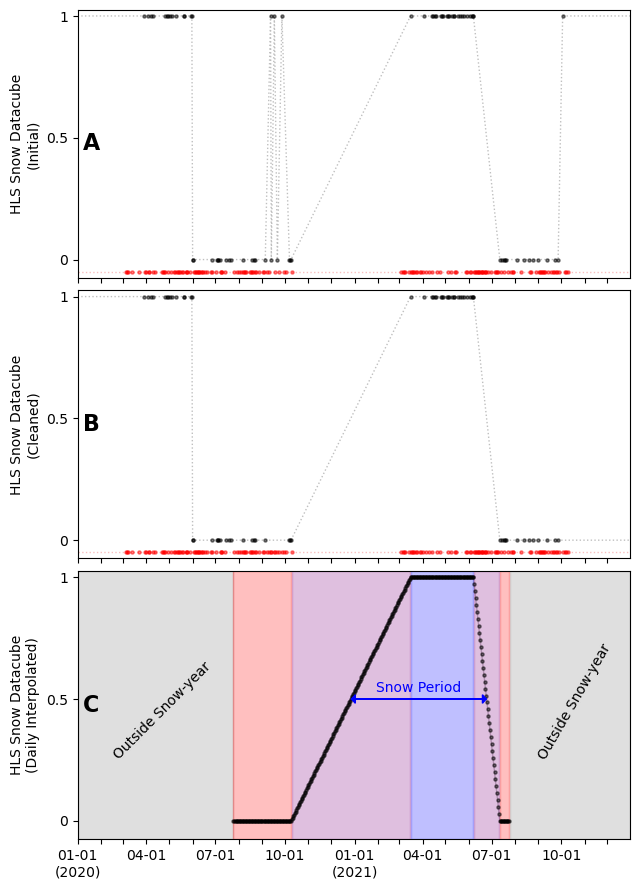

In [26]:
fig, axs = plt.subplots(3, 1, figsize = (6.5, 9), sharex = True, sharey = True)

size = 5
alpha = 0.5

# A
axs[0].text(0.01, 0.5, 'A', fontsize = 16, weight = 'bold', transform = axs[0].transAxes, va = 'center')

axs[0].scatter(df2.index, df2['SnowCube_pts'], c = 'black', s = size, zorder = 1, alpha = alpha)
axs[0].plot(df2.index, df2['SnowCube_line'], c = 'gray', linewidth = 1, linestyle = 'dotted', zorder = 0, alpha = alpha)

axs[0].scatter(df2.index, df2['unclear_pts'], c = 'red', s = size, zorder = 1, alpha = alpha)
axs[0].plot(df2.index, df2['unclear_line'], c = 'lightcoral', linewidth = 1, linestyle = 'dotted', zorder = 0, alpha = alpha)

axs[0].set_ylabel('HLS Snow Datacube\n(Initial)')

# B
axs[1].text(0.01, 0.5, 'B', fontsize = 16, weight = 'bold', transform = axs[1].transAxes, va = 'center')

axs[1].scatter(df2.index, df2['SnowCube_c_pts'], c = 'black', s = size, zorder = 1, alpha = alpha)
axs[1].plot(df2.index, df2['SnowCube_c_line'], c = 'gray', linewidth = 1, linestyle = 'dotted', zorder = 0, alpha = alpha)

axs[1].scatter(df2.index, df2['unclear_c_pts'], c = 'red', s = size, zorder = 1, alpha = alpha)
axs[1].plot(df2.index, df2['unclear_line'], c = 'lightcoral', linewidth = 1, linestyle = 'dotted', zorder = 0, alpha = alpha)

axs[1].set_ylabel('HLS Snow Datacube\n(Cleaned)')

# C
axs[2].text(0.01, 0.5, 'C', fontsize = 16, weight = 'bold', transform = axs[2].transAxes, va = 'center')
axs[2].text(0.06, 0.3, 'Outside Snow-year', fontsize = 10,  transform = axs[2].transAxes, rotation = 45)
axs[2].text(0.83, 0.3, 'Outside Snow-year', fontsize = 10,  transform = axs[2].transAxes, rotation = 60)

axs[2].fill_between(df2.index, -0.075, 1.025, where = df2['SnowCube_1D'].isnull(), color = 'gray', alpha = 0.25)
axs[2].fill_between(df2.index, -0.075, 1.025, where = df2['SnowCube_1D'] == 1, color = 'blue', alpha = 0.25)
axs[2].fill_between(df2.index, -0.075, 1.025, where = (df2['SnowCube_1D'] > 0) & (df2['SnowCube_1D'] < 1), color = 'purple', alpha = 0.25)
axs[2].fill_between(df2.index, -0.075, 1.025, where = df2['SnowCube_1D'] == 0, color = 'red', alpha = 0.25)
# axs[2].axvline(df2[df2['SnowCube_1D'].notnull()].iloc[0:1].index)
# axs[2].axvline(df2[df2['SnowCube_1D'].notnull()].iloc[-1:].index)

axs[2].scatter(df2.index, df2['SnowCube_1D'], c = 'black', s = size, zorder = 1, alpha = alpha)
axs[2].plot(df2.index, df2['SnowCube_1D'], c = 'gray', linewidth = 1, linestyle = 'solid', zorder = 0, alpha = alpha)

axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2020-12-28')), dy = 0, dx = 178, 
             length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2021-06-24')), dy = 0, dx = -178, 
             length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
axs[2].text(0.54, 0.55, 'Snow Period', fontsize = 10,  transform = axs[2].transAxes, color = 'blue')

# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2022-11-11')), dy = 0, dx = 164, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-04-24')), dy = 0, dx = -164, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-05-07')), dy = 0, dx = 16, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].arrow(y = 0.5, x = mpl.dates.date2num(pd.Timestamp('2023-05-23')), dy = 0, dx = -16, 
#              length_includes_head = True, head_width = 0.035, head_length = 5, color = 'blue')
# axs[2].text(0.47, 0.55, 'Snow Periods', fontsize = 10,  transform = axs[2].transAxes, color = 'blue')

axs[2].set_xlim([pd.Timestamp('2020-01-01'), pd.Timestamp('2021-12-31')])
axs[2].set_xticks([pd.Timestamp('2020-01-01'), pd.Timestamp('2020-02-01'), pd.Timestamp('2020-03-01'), pd.Timestamp('2020-04-01'),
                   pd.Timestamp('2020-05-01'), pd.Timestamp('2020-06-01'), pd.Timestamp('2020-07-01'), pd.Timestamp('2020-08-01'),
                   pd.Timestamp('2020-09-01'), pd.Timestamp('2020-10-01'), pd.Timestamp('2020-11-01'), pd.Timestamp('2020-12-01'),
                   pd.Timestamp('2021-01-01'), pd.Timestamp('2021-02-01'), pd.Timestamp('2021-03-01'), pd.Timestamp('2021-04-01'),
                   pd.Timestamp('2021-05-01'), pd.Timestamp('2021-06-01'), pd.Timestamp('2021-07-01'), pd.Timestamp('2021-08-01'),
                   pd.Timestamp('2021-09-01'), pd.Timestamp('2021-10-01'), pd.Timestamp('2021-11-01'), pd.Timestamp('2021-12-01')],
                  ['01-01\n(2020)', '', '', '04-01', '', '', '07-01', '', '', '10-01', '', '',
                   '01-01\n(2021)', '', '', '04-01', '', '', '07-01', '', '', '10-01', '', ''])

axs[2].set_ylim(-0.075, 1.025)
axs[2].set_yticks([0, 0.5, 1], ['0', '0.5', '1'])
axs[2].set_ylabel('HLS Snow Datacube\n(Daily Interpolated)')

plt.tight_layout(h_pad = 0.5, w_pad = 0)

plt.show()

fig.get_figure().savefig('Figure A30.tif', dpi = 600, bbox_inches = 'tight', pil_kwargs = {'compression': 'tiff_lzw'})

In [67]:
# import datetime
# mpl.dates.date2num(pd.Timestamp('2022-05-01'))

In [68]:
# binary = df2['SnowCube_1D'].where(df2['SnowCube_1D'].notnull(), 1)
# binary

In [69]:
# df2['SnowCube_1D'].values > 0.5
# df2['SnowCube_1D'].isnull()

In [70]:
# df2['SnowCube_1D'][530:560]

In [51]:
# mpl.dates.date2num(pd.Timestamp('2023-05-23')) - mpl.dates.date2num(pd.Timestamp('2022-11-08'))